# Applying DeepAR to time series forecasting of Well and Riser flow rates

## Author: Ridha Alkhabaz

This is notebook to explore Prophet algorithm viability to predict mass flow rates in a off-shore riser. Specifically, we are investigating gas mass flow rate in this notebook. 


## Imports:

In [1]:
import os
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML/src')
from preprocessing import read_data_slugging, read_data_well, time_to_timestamp
from configuration import configure 
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML')
import datetime
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from itertools import islice
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.field_names import FieldName

#### Reading the data and visualization:

Our split here is to use the previous 10 periods to predict the last period. 

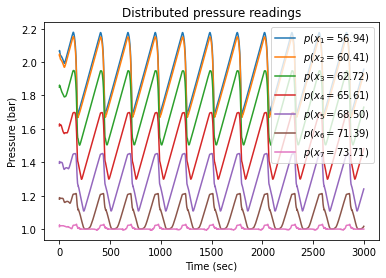

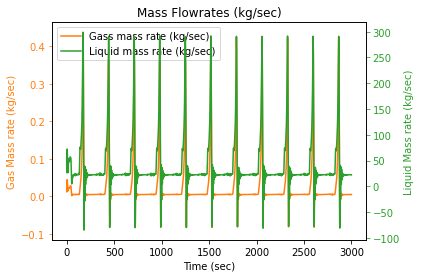

In [2]:
df,data_slugging,headers, _= read_data_slugging('riser_pq_uni.csv', plot_data=True)
df['date'] = df['ds'].apply(time_to_timestamp)
df = df.set_index('date')
df = df.drop(['ds'], axis=1)
df = df.rename(columns={'gas(kg/sec)':'gas'})
### configuration for training
prediction_length=270
training_data_uni = ListDataset(
    [{"start":df.index[0],  "target":df.gas[:'2021-07-11 11:00:00']}],
    freq = "1min"
)
training_data_mult = ListDataset(
    [{"start":df.index[0], "feat_dynamic_real":df.iloc[:,0:7].values, "target":df.gas[:'2021-07-11 11:00:00']}],
    freq = "1min"
)
### configuration for testing 
test_data_uni = ListDataset(
    [{"start": df.index[0], "target": df.gas[:'2021-07-11 11:00:00']}, 
    {"start": df.index[0], "target": df.gas[:'2021-07-12 01:59:00']}],
    freq = "1min"
)
test_data_mult = ListDataset(
    [{"start": df.index[0], "feat_dynamic_real":df.iloc[:,0:7].values, "target": df.gas[:'2021-07-11 11:00:00']}, 
    {"start": df.index[0], "feat_dynamic_real":df.iloc[:,0:7].values,"target": df.gas[:'2021-07-12 01:59:00']}],
    freq = "1min"
)

#### Initialization:
We are trying to find the difference between univariate, multivairate, tuned and basic implementation of DeepAR. 

In [68]:
uni = {'freq':'1min', 'context_length':600, 'prediction_length':200, \
     'num_layers':4, 'num_cells':256, 'cell_type':'gru', 'trainer':Trainer(epochs=10)}
multi = {'freq':'1min', 'context_length':600, 'prediction_length':200, \
     'num_layers':4, 'num_cells':256, 'cell_type':'gru', 'trainer':Trainer(epochs=10)}

In [69]:
deepar_uni = DeepAREstimator(**uni)
deepar_multi = DeepAREstimator(**multi)

#### Training:
We train our model on the training data.

In [70]:
predictor_uni = deepar_uni.train(training_data_uni)

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
predictor_mult = deepar_multi.train(training_data_mult)

#### Testing


In [62]:
forecast_it_uni, test_it_uni = make_evaluation_predictions(
    dataset=test_data_uni,
    predictor=predictor_uni, 
    num_samples=1000
)
forecasts_uni = list(forecast_it_uni)
tss_uni = list(test_it_uni)
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metric_uni, item_metrics_uni= evaluator(iter(tss_uni), iter(forecasts_uni), num_series=len(test_data_uni))

Running evaluation: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


In [63]:
forecast_it_mult, test_it_mult = make_evaluation_predictions(
    dataset=test_data_mult,
    predictor=predictor_mult, 
    num_samples=1000
)
forecasts_mult = list(forecast_it_mult)
tss_mult = list(test_it_mult)
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metric_mult, item_metrics_mult= evaluator(iter(tss_mult), iter(forecasts_mult), num_series=len(test_data_mult))

Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 31.79it/s]


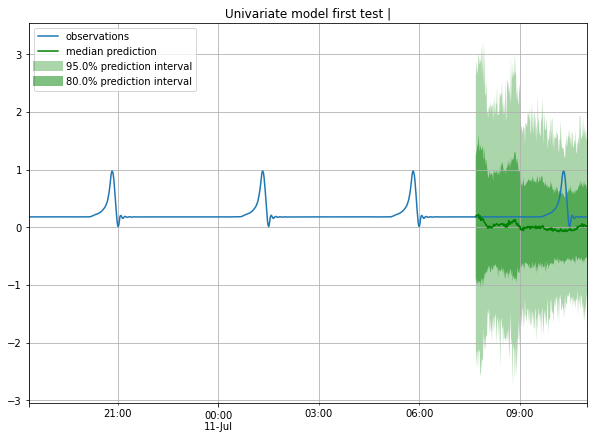

In [64]:
plot_prob_forecasts(tss_uni[0], forecasts_uni[0], 'Univariate model first test |')

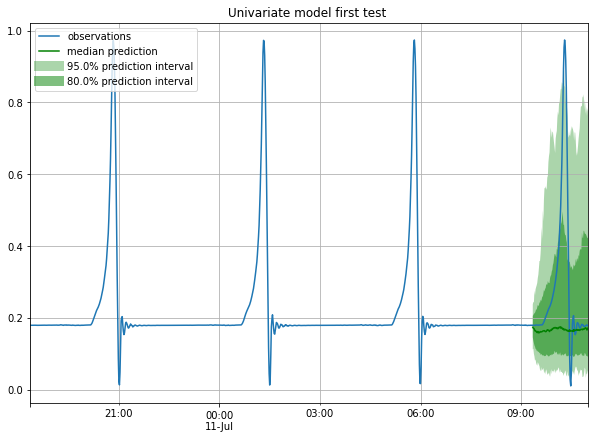

In [25]:
plot_prob_forecasts(tss_uni[0], forecasts_uni[0], 'Univariate model first test ')

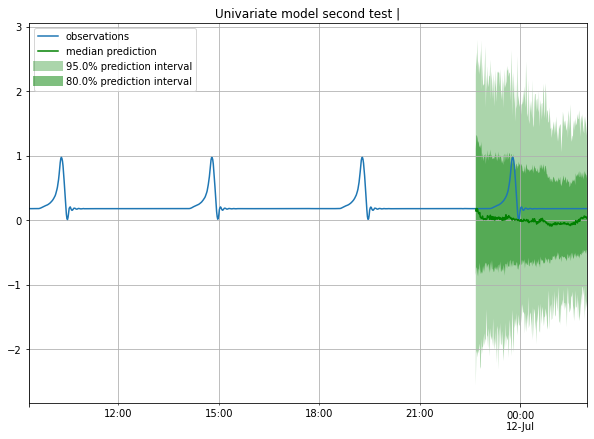

In [65]:
plot_prob_forecasts(tss_uni[1], forecasts_uni[1], 'Univariate model second test |')

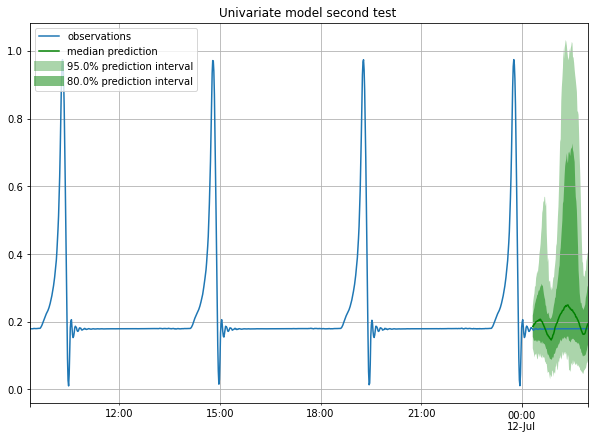

In [26]:
plot_prob_forecasts(tss_uni[1], forecasts_uni[1], 'Univariate model second test ')

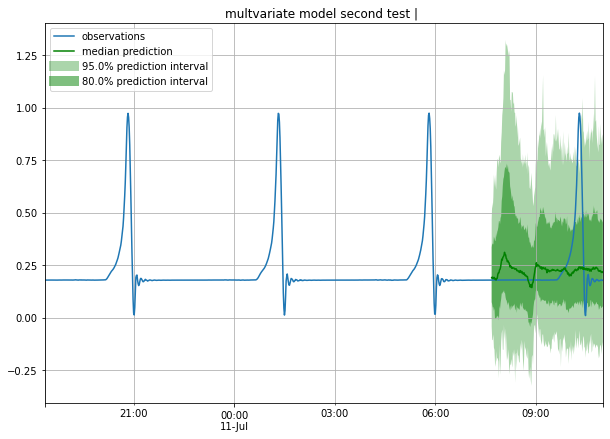

In [66]:
plot_prob_forecasts(tss_mult[0], forecasts_mult[0], 'multvariate model second test | ')

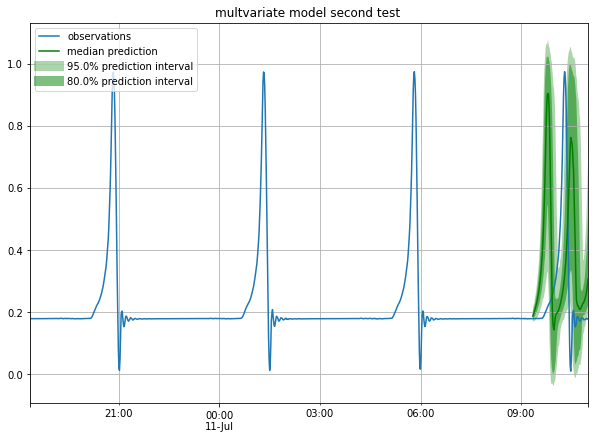

In [27]:
plot_prob_forecasts(tss_mult[0], forecasts_mult[0], 'multvariate model second test ')

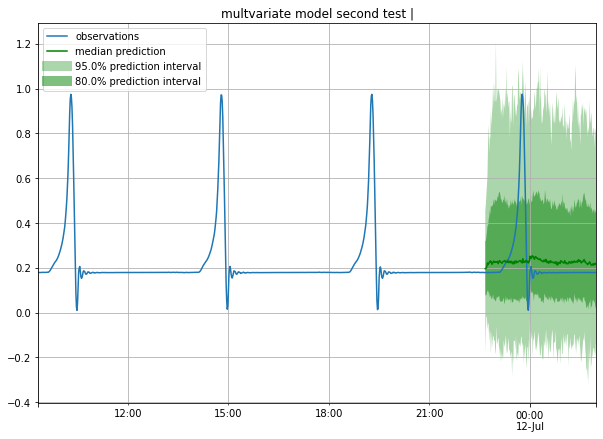

In [67]:
plot_prob_forecasts(tss_mult[1], forecasts_mult[1], 'multvariate model second test |')

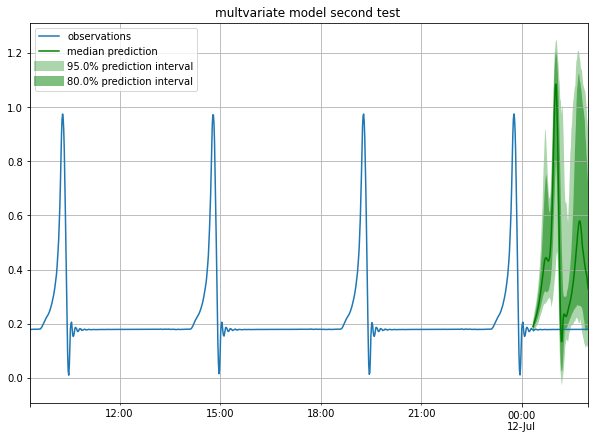

In [28]:
plot_prob_forecasts(tss_mult[1], forecasts_mult[1], 'multvariate model second test ')

#### Appendix 
we are going to include some functions that may only apply for this notebook


In [14]:
def plot_prob_forecasts(ts_entry, forecast_entry, title):
    plot_length = 1000
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.set_title(title)
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [39]:
print('hi')

hi
